In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as integrate
from cycler import cycler
%matplotlib inline
matplotlib.rcParams.update({'font.size': 20, 'figure.figsize': (10,6), 'text.usetex': True, 'grid.linestyle': ':',
                           'image.cmap': 'gray'})

In [2]:
N = 100
rMax = 10
samples = 1000
dx = rMax/samples

In [3]:
def deriv(phi):
    dphi = np.gradient(phi, dx)
    return dphi

def innerProd(u, v, r):
    integrand = 2*np.pi*u*v*r
    return integrate.simps(integrand, r)

def projection(u, v, r):
    return (innerProd(u, v, r)/innerProd(u, u, r))*u

def gramSchmidt(vectors, r = np.linspace(0, rMax, samples)):
    orthoNorm = []
    for i in range(len(vectors)):
        for j in range(len(orthoNorm)):
            vectors[i] = vectors[i] -  projection(orthoNorm[j], vectors[i], r)
        orthoNorm.append(vectors[i]/np.sqrt(innerProd(vectors[i], vectors[i], r)))
    return np.array(orthoNorm)

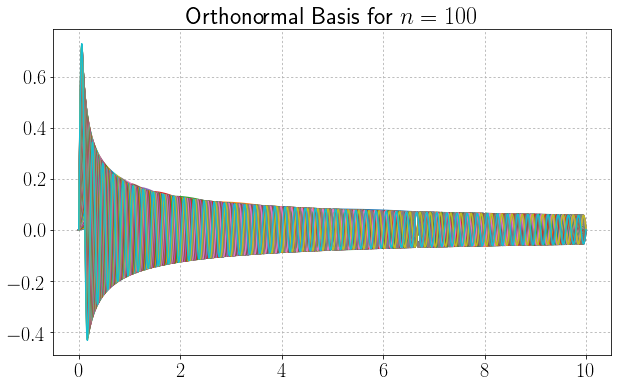

In [4]:
x = np.linspace(0, rMax, samples)
basis = [np.sin(np.pi*n*x/rMax) for n in range(1, N + 1)]
orthNorm = gramSchmidt(basis, x)
for el in orthNorm:
    plt.plot(x, el)
plt.grid()
plt.title(r'Orthonormal Basis for $n = {0}$'.format(N))
#plt.savefig('/Users/natestemen/Desktop/basis.pdf')

In [111]:
innerProds = [[] for i in range(len(orthNorm))]
for i in range(len(orthNorm)):
    for j in range(i):
        innerProds[i].append(innerProd(orthNorm[i],orthNorm[j], x))

test = True
for i in range(len(innerProds)):
    for j in range(i):
        if innerProds[i][j] > 1e-16:
            test = False
            print(i,j,':', innerProds[i][j])
print(innerProds[4][1])

12 11 : 1.24685367418e-16
19 18 : 1.82387792884e-16
30 29 : 1.20326112355e-16
31 29 : 1.07599442323e-16
31 30 : 1.51782374917e-16
33 32 : 1.03508273187e-16
35 32 : 1.11067195209e-16
38 36 : 1.11837148158e-16
39 38 : 1.07166608487e-16
3.00967349772e-17


In [112]:
def approx_soln(var):
    if len(var) != N:
        print('variational vector not of correct size')
    else:
        approx = np.zeros(len(orthNorm[0]))
        for i in range(len(var)):
            approx += var[i]*orthNorm[i]
        return approx

In [113]:
def functional(varVector, n = 1, a = 2, b = 1.1, lam = 1):
    phi = approx_soln(varVector)
    dphi = deriv(phi)
    kinetic1 = x*(dphi**2)
    kinetic2 = (n**2)*(phi**2)[1:]/x[1:]
    kinetic2 = np.insert(kinetic2,0,0)
    kinetic = kinetic1 + kinetic2
    potential = phi**6 - a*(phi**4) + b*(phi**2)
    integrand = 0.5*kinetic + lam*x*potential
    return integrate.simps(integrand, x)

$$I[\phi] = \int_0^R \left[\frac{1}{2}\left(\rho\phi_\rho^2 + \frac{n^2}{\rho}\phi^2\right) + \lambda\rho\left(\phi^6 - a\phi^4 + b\phi^2\right)\right]\mathrm{d}\rho$$

In [114]:
def lag_multiplier(soln, n = 1, a = 2, b = 1.1, lam = 1):
    dsoln = np.gradient(soln, dx)
    integrand1 = x[1:]*dsoln[1:]**2 + (n**2/x[1:])*(soln[1:])**2 + lam*x[1:]*(6*soln[1:]**6 - 4*a*soln[1:]**4 + 2*b*soln[1:]**2)
    integrand1 = np.insert(integrand1, 0, 0)
    deltaI = integrate.simps(integrand1, x)
    integrand2 = 4*np.pi*x*soln**2
    deltaJ = integrate.simps(integrand2, x)
    return deltaI/deltaJ

$$\rho^2\phi_{\rho\rho} + \rho\phi_\rho - n^2\phi - \lambda\rho^2\left(6\phi^5 - 4a\phi^3 + 2b\phi\right) + \omega^2\rho^2 \phi = 0$$

In [18]:
def error(soln, omega, n = 1, a = 2, b = 1.1, lam = 1):
    dsoln = np.gradient(soln, dx)
    ddsoln = np.gradient(dsoln, dx)
    first = (x**2)*ddsoln
    second = x*dsoln
    third = -1*(n**2)*soln
    fourth = -1*lam*(x**2)*(6*soln**5 - 4*a*soln**3 + 2*b*soln)
    fifth = (omega**2)*(x**2)*soln
    DE = first + second + third + fourth + fifth
    #return DE
    return integrate.simps(DE**2, x)

In [19]:
def min_func(J0, n = 1, a = 2, b = 1.1, lam = 1, disp = False, succ = False):
    '''returns solution array, omega, and error'''
    guess = np.array([np.sqrt(J0/N) for i in range(N)])
    cons = ({'type': 'eq', 'fun': lambda x:  sum(x**2) - J0})
    ops = ({'maxiter': 1000, 'disp': disp})
    minimum = minimize(functional, guess, args = (n, a, b, lam), constraints = cons, options = ops)
    soln = approx_soln(minimum.x)
    omega = np.sqrt(4*np.pi*lag_multiplier(soln, n, a, b, lam))
    err = error(soln, omega, n, a, b, lam)
    #return err
    if succ:
        return soln, omega, err, minimum.success
    return soln, omega, err

In [65]:
def vary_pow(Js, n = 1, a = 2, b = 1.1, lam = 1):
    solns = {}
    omegs = {}
    errs = {}
    count = 0
    for j in Js:
        print(j)
        s,o,e,t = min_func(j, n, a, b, lam, succ = True)#, disp=True)
        if not t:
            print('minimization failed for J = ' + str(j))
        solns[j] = s
        omegs[j] = o
        errs[j] = e
        count += 1
    return solns, omegs, errs

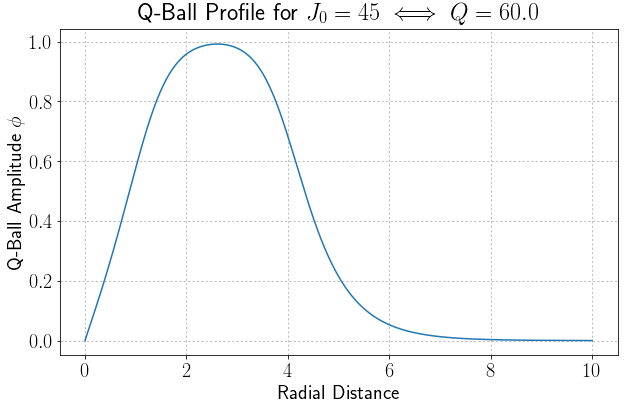

In [174]:
J = 45
#soln,omega,err = min_func(J)
s,o,e = min_func(J, n = 1)
#plt.figure(figsize = (10, 6))
plt.plot(np.linspace(0, rMax, samples), abs(s))
plt.xlabel('Radial Distance')
plt.ylabel('Q-Ball Amplitude $\phi$')
plt.title('Q-Ball Profile for $J_0 = {0}\iff Q = {1}$'.format(J, round(4*np.pi*o*integrate.simps(x*s**2,x), 1)))
plt.grid()
#plt.savefig('/Users/natestemen/Desktop/qballprof30.pdf')
#print(integrate.simps(err**2, x))

In [144]:
e

0.0017902734230431342

In [145]:
o

0.66672225724994272

In [146]:
4*np.pi*o*integrate.simps(x*s**2,x)

60.005003976672754

In [178]:
pows = np.arange(10, 100, 20)
s,o,e = vary_pow(pows)

10
30
50
70
90


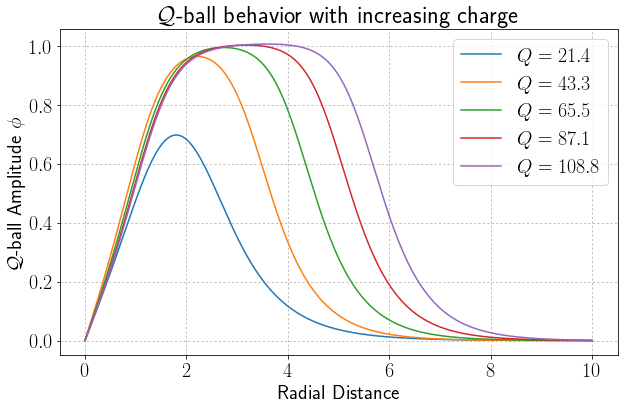

In [179]:
for soln in s:
    plt.plot(x, abs(s[soln]), label = '$Q = {0}$'.format(round(4*np.pi*o[soln]*integrate.simps(x*s[soln]**2,x),1)))
    plt.legend()
    plt.grid()
    plt.xlabel('Radial Distance')
    plt.ylabel('$\mathcal{Q}$-ball Amplitude $\phi$')
    plt.title('$\mathcal{Q}$-{ball} behavior with increasing charge')
plt.savefig('/Users/natestemen/Desktop/varypowercharge.pdf')

In [125]:
for n in o:
    print(str(n) +  ' & ' + str(round(o[n],5)) + ' & ' +  str(round(e[n],6)) + '\\ \hline')

10 & 1.06898 & 1.7e-05\ \hline
20 & 0.80058 & 0.00498\ \hline
30 & 0.72156 & 0.006263\ \hline
40 & 0.68074 & 0.001366\ \hline
50 & 0.65481 & 0.004466\ \hline
60 & 0.63783 & 0.03409\ \hline
70 & 0.62205 & 0.022635\ \hline
80 & 0.61019 & 0.004268\ \hline
90 & 0.60444 & 0.065956\ \hline


In [186]:
powers = np.linspace(0.1, 200.1, 401)
sScan,oScan,eScan = vary_pow(powers)

0.1
0.6
1.1
1.6
2.1
2.6
3.1
3.6
4.1
4.6
5.1
5.6
6.1
6.6
7.1
7.6
8.1
8.6
9.1
9.6
10.1
10.6
11.1
11.6
12.1
12.6
13.1
13.6
14.1
14.6
15.1
15.6
16.1
16.6
17.1
17.6
18.1
18.6
19.1
19.6
20.1
20.6
21.1
21.6
22.1
22.6
23.1
23.6
24.1
24.6
25.1
25.6
26.1
26.6
27.1
27.6
28.1
28.6
29.1
29.6
30.1
30.6
31.1
31.6
32.1
32.6
33.1
33.6
34.1
34.6
35.1
35.6
36.1
36.6
37.1
37.6
38.1
38.6
39.1
39.6
40.1
40.6
41.1
41.6
42.1
42.6
43.1
43.6
44.1
44.6
45.1
45.6
46.1
46.6
47.1
47.6
48.1
48.6
49.1
49.6
50.1
50.6
51.1
51.6
52.1
52.6
53.1
53.6
54.1
54.6
55.1
55.6
56.1
56.6
57.1
57.6
58.1
58.6
59.1
59.6
60.1
60.6
61.1
61.6
62.1
62.6
63.1
63.6
64.1
64.6
65.1
65.6
66.1
66.6
67.1
67.6
68.1
68.6
69.1
69.6
70.1
70.6
71.1
71.6
72.1
72.6
73.1
73.6
74.1
74.6
75.1
75.6
76.1
76.6
77.1
77.6
78.1
78.6
79.1
79.6
80.1
80.6
81.1
81.6
82.1
82.6
83.1
83.6
84.1
84.6
85.1
85.6
86.1
86.6
87.1
87.6
88.1
88.6
89.1
89.6
90.1
90.6
91.1
91.6
92.1
92.6
93.1
93.6
94.1
94.6
95.1
95.6
96.1
96.6
97.1
97.6
98.1
98.6
99.1
99.6
100.1
100.6
101.1
10

In [201]:
def calcQs(solns, omegs):
    Qs = {}
    for p in solns:
        Qs[p] = 2*p*omegs[p]
    return Qs

In [202]:
Qs = calcQs(sScan, oScan)

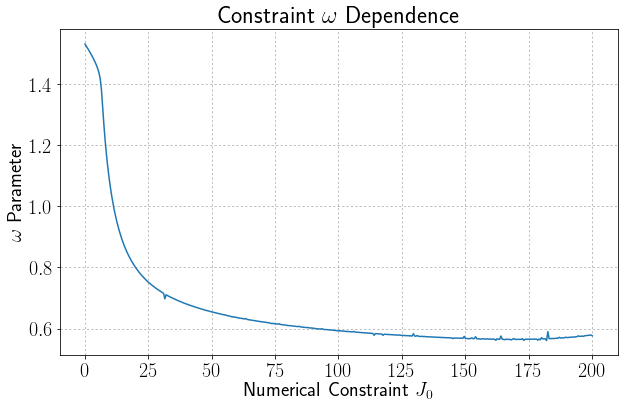

In [248]:
plt.plot([i for i in Qs],[i for i in oScan.values()])
#plt.plot([i for i in o.values()], powers)
plt.ylabel('$\omega$ Parameter')
plt.xlabel('Numerical Constraint $J_0$')
plt.title('Constraint $\omega$ Dependence')
plt.grid()
plt.savefig('/Users/natestemen/Desktop/omegascan.pdf')

In [242]:
for ind in oScan:
    if ind > 100:
        if oScan[ind] > 0.602:
            faulty = ind
            print(ind, oScan[ind])

105.6 0.644051092033


In [237]:
specialsoln, specialom, specialerr = min_func(J0 = 105.5, disp = True)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5.06816383512
            Iterations: 384
            Function evaluations: 20256
            Gradient evaluations: 384


In [243]:
oScan[faulty] = specialom

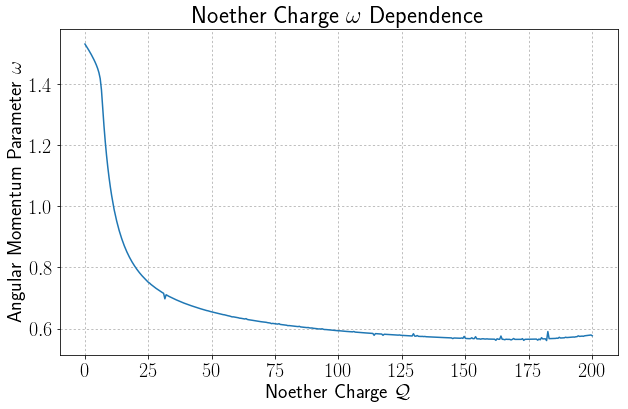

In [246]:
plt.plot([i for i in Qs],[i for i in oScan.values()])
#plt.plot([i for i in o.values()], powers)
plt.ylabel('Angular Momentum Parameter $\omega$')
plt.xlabel('Noether Charge $\mathcal{Q}$')
plt.title('Noether Charge $\omega$ Dependence')
plt.grid()

In [235]:
li = list(oScan.values())
for i in range(1, len(li)):
    if abs(li[i] - li[i - 1]) > 0.04:
        print(i, li[i])
#     if n > 125:
#         if oScan[n] > 0.6:
#             faulty = n
#             print(n, oScan[n])

KeyError: 14

In [229]:
D = {1:2, 5:7}
len(D.values())

2

In [213]:
specialsoln, specialom, specialerr = min_func(J0 = 170.55, disp = True)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.7720970549
            Iterations: 513
            Function evaluations: 27134
            Gradient evaluations: 513


In [214]:
specialom

0.56487800945319666

In [215]:
oScan[faulty] = specialom

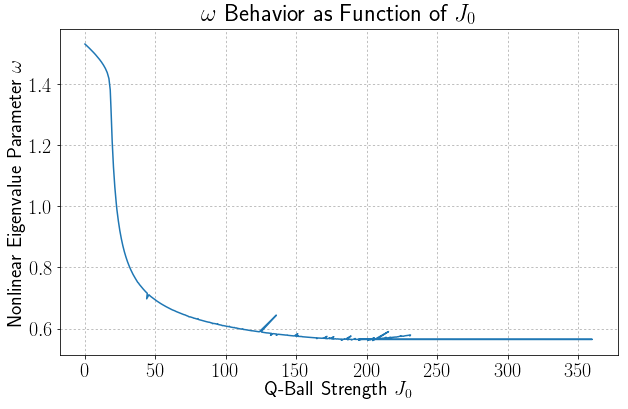

In [216]:
plt.plot([i for i in Qs.values()], [i for i in oScan.values()])
plt.ylabel('Nonlinear Eigenvalue Parameter $\omega$')
plt.xlabel('Q-Ball Strength $J_0$')
plt.title('$\omega$ Behavior as Function of $J_0$')
plt.grid()
plt.savefig('/Users/natestemen/Desktop/omegavJ.pdf')

In [52]:
powers = np.linspace(200, 400, 400)
s1,o1,e1 = vary_pow(powers)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7.53218347232
            Iterations: 440
            Function evaluations: 23192
            Gradient evaluations: 440
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7.54562338115
            Iterations: 412
            Function evaluations: 21663
            Gradient evaluations: 412
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7.55963972569
            Iterations: 402
            Function evaluations: 21146
            Gradient evaluations: 402
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7.5725061589
            Iterations: 411
            Function evaluations: 21617
            Gradient evaluations: 411
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7.58600405216
            Iterations: 469
            Function eva

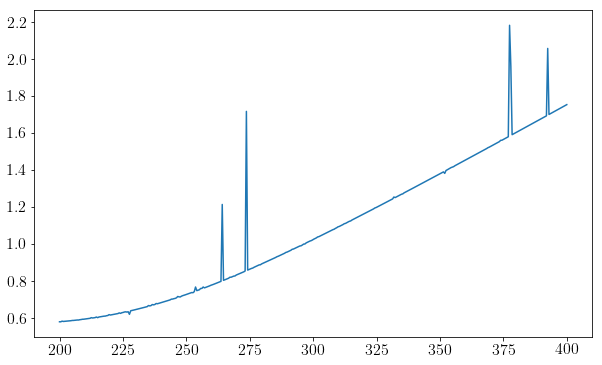

In [53]:
plt.plot(powers, [i for i in o1.values()])

In [54]:
powers = np.linspace(400, 600, 400)
s2,o2,e2 = vary_pow(powers)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 27.7740410308
            Iterations: 531
            Function evaluations: 28024
            Gradient evaluations: 531
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 27.8971109838
            Iterations: 897
            Function evaluations: 47675
            Gradient evaluations: 897
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 28.020713413
            Iterations: 651
            Function evaluations: 34591
            Gradient evaluations: 651
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 28.1448495969
            Iterations: 695
            Function evaluations: 36945
            Gradient evaluations: 695
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 28.269521426
            Iterations: 656
            Function eval

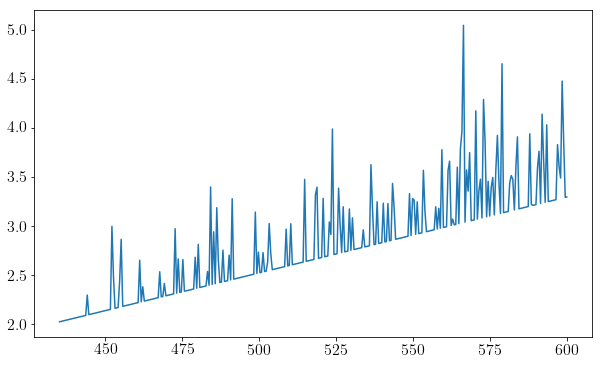

In [58]:
#plt.plot(powers, [i for i in o2.values()])
js = []
os = []
for n in o2:
    if n > 435:
        js.append(n)
        os.append(o2[n])
plt.plot(js,os)

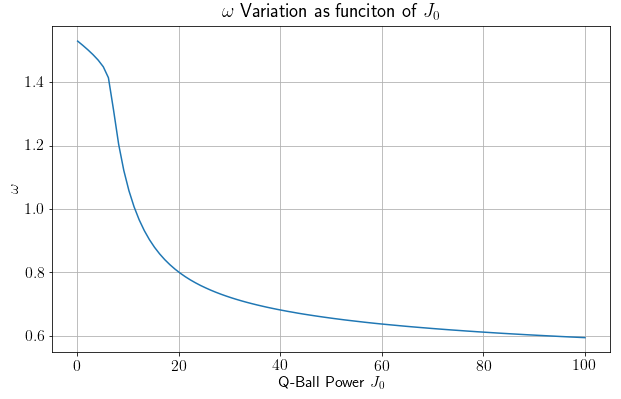

In [47]:
power = np.linspace(0.1,100,100)
soln = []
omega = []
err = []
count = 0
for p in power:
    s,o,e,t = min_func(p, succ = True)
    if not t:
        print(p)
    soln.append(s)
    omega.append(o)
    err.append(e)
plt.figure(figsize = (10, 6))
plt.plot(power, omega)
plt.title(r'$\omega$ Variation as function of $J_0$')
plt.xlabel(r'Q-Ball Power $J_0$')
plt.ylabel(r'$\omega$')
plt.grid()

1.0
3.0101010101
5.0202020202
7.0303030303
9.0404040404
11.0505050505
13.0606060606
15.0707070707
17.0808080808
19.0909090909
21.101010101
23.1111111111
25.1212121212
27.1313131313
29.1414141414
31.1515151515
33.1616161616
35.1717171717
37.1818181818
39.1919191919
41.202020202
43.2121212121
45.2222222222
47.2323232323
49.2424242424
51.2525252525
53.2626262626
55.2727272727
57.2828282828
59.2929292929
61.303030303
63.3131313131
65.3232323232
67.3333333333
69.3434343434
71.3535353535
73.3636363636
75.3737373737
77.3838383838
79.3939393939
81.404040404
83.4141414141
85.4242424242
87.4343434343
89.4444444444
91.4545454545
93.4646464646
95.4747474747
97.4848484848
99.4949494949
101.505050505
103.515151515
105.525252525
107.535353535
109.545454545
111.555555556
113.565656566
115.575757576
117.585858586
119.595959596
121.606060606
123.616161616
125.626262626
127.636363636
129.646464646
131.656565657
133.666666667
135.676767677
137.686868687
139.696969697
141.707070707
143.717171717
145.727272

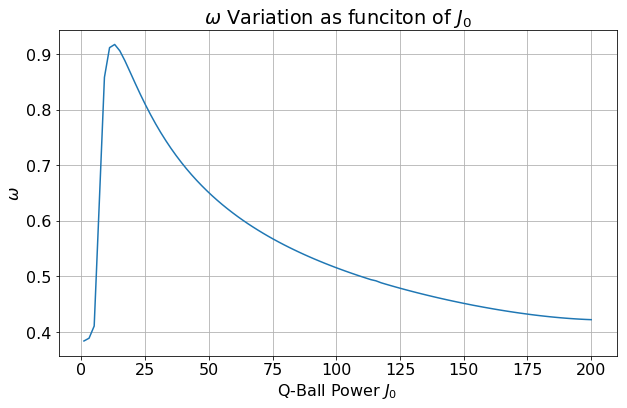

In [49]:
power = np.linspace(1,200,100)
soln = []
omega = []
err = []
count = 0
for p in power:
    print(p)
#     if int(p)%10 == 0:
#         print(int(p))
    s,o,e,t = min_func(p, succ = True)
    if not t:
        print(t)
    soln.append(s)
    omega.append(o)
    err.append(e)
plt.figure(figsize = (10, 6))
plt.plot(power, omega)
plt.title(r'$\omega$ Variation as funciton of $J_0$')
plt.xlabel(r'Q-Ball Power $J_0$')
plt.ylabel(r'$\omega$')
plt.grid()

Want to show if this is correct, so need some error estimate. $$\int_0^R(D\phi)^2 = 0$$

$$D\phi = \phi_{\rho\rho}+\dfrac{1}{\rho}\phi_{\rho}-\dfrac{n^2}{\rho^2}\phi-\lambda\left(6\phi^5-4a\phi^3+2b\phi\right)+\omega^2\phi = 0$$

This is equivalent to
$$\rho^2\phi_{\rho\rho} + \rho\phi_\rho - n^2\phi - \lambda\rho^2\left(6\phi^5 - 4a\phi^3 + 2b\phi\right) + \omega^2\rho^2 \phi = 0$$

In [190]:
def findMins(nVals, J0, a, b, lam):
    solns = {}
    omegs = {}
    errs = {}
    start = np.array([np.sqrt(J0/N) for i in range(N)])
    ops = ({'maxiter': 1000, 'disp': False})
    cons = ({'type': 'eq', 'fun': lambda x: sum(x**2) - J0})
    for n in nVals:
        minimum = minimize(functional, start, args = (n, a, b, lam), constraints = cons, options = ops)
        minVarVector = minimum.x
        soln = approx_soln(minVarVector)
        omega = np.sqrt(4*np.pi*lag_multiplier(soln, n, a, b, lam))
        err = error(soln, omega, n, a, b, lam)
        solns[n] = soln
        omegs[n] = omega
        errs[n] = err
    return solns, omegs, errs

In [191]:
s,o,e = findMins([1,2,3], 45, 2, 1.1, 1)

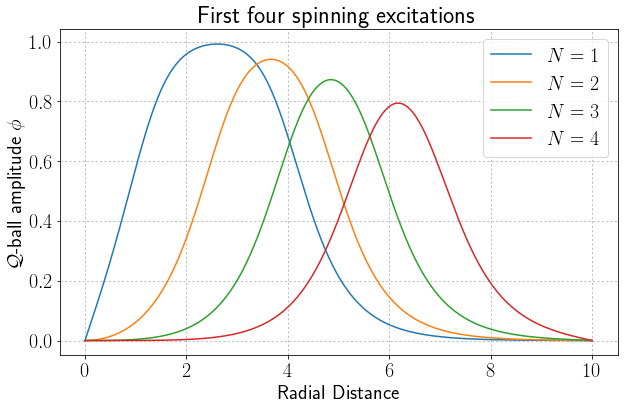

In [200]:
for ind in s:
    plt.plot(x, abs(s[ind]), label = "$N = {0}$".format(ind))
plt.legend()
plt.title('First four spinning excitations')
plt.ylabel('$\mathcal{Q}$-ball amplitude $\phi$')
plt.xlabel('Radial Distance ')
plt.grid()
plt.savefig('/Users/natestemen/Desktop/firstfour.pdf')

In [218]:
for n in o:
    print('n = ' + str(n) + ' -> omega = ' + str(o[n]))
    #print(o[n])

n = 1 -> omega = 0.66672225725
n = 2 -> omega = 0.751293252186
n = 3 -> omega = 0.846849748715
n = 4 -> omega = 0.952076110851


In [225]:
2*np.pi*integrate.simps(x*abs(s[4])**2,x)

45.0000001197483

In [188]:
list(range(1,5))

[1, 2, 3, 4]